# Think Bayes: Chapter 14

Note: this exercise has been taken from the Think Bayes [book](http://www.greenteapress.com/thinkbayes/thinkbayes.pdf)

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

import os, sys

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

** Question **

This exercise is inspired by an example in Jaynes, Probability
Theory.

Suppose you buy a mosquito trap that is supposed to reduce the population of
mosquitoes near your house. Each week, you empty the trap and count the number
of mosquitoes captured. After the first week, you count 30 mosquitoes. After
the second week, you count 20 mosquitoes. Estimate the percentage change in the
number of mosquitoes in your yard.

To answer this question, you have to make some modeling decisions. Here are some
suggestions:

• Suppose that each week a large number of mosquitoes, N, is bred in a wetland
near your home.

• During the week, some fraction of them, f1, wander into your yard, and of
those some fraction, f2, are caught in the trap.

• Your solution should take into account your prior belief about how much N
is likely to change from one week to the next. You can do that by adding a
level to the hierarchy to model the percent change in N.

** Solution **

First, lets consider the causal relationship between these variables.

Given some number of mosquitos who have bred, f1 will go to my home. Let's assume each mosquito acts independently, in which case this can be described using a binomial distribution; given that each mosquito has a probability p1 of going to my home, f1 is a binomial distribution with parameters p1 and N.

Equally, assuming independence in the traps, and a probability p2 of being trapped, the mosquitos who are trapped can be described by a binomial distribution with parameters p2 and f1.

Finally, I need to have some prior belief in how N will change from one week to the next. Let's assume that they halve from one week to the next, since the trap worked (hopefully).

** Step 1: ratio of mosquitos trapped **

Let's assume for this step that **p2** is 100.

In [2]:
from thinkbayes2 import MakeUniformPmf, EvalBinomialPmf, MakeBinomialPmf

In [30]:
class Trapped(Suite):
    """
    Calculate the distribution of f2, the fraction of
    mosquitoes caught in the trap
    """
    def __init__(self, f1, N, low=0, high=1, n=10):
        pmf = MakeUniformPmf(low, high, n)
        Suite.__init__(self, pmf)
        
        self.f1 = f1
        self.N = N
    
    def Likelihood(self, data, hypo):
        k = data
        f2 = hypo
        f1 = self.f1
        N = self.N
        
        # first, we calculate how many mosquitoes
        # went into the yard
        p1_dist = MakeBinomialPmf(N, f1)
        
        like = 0
        for p1, prob in p1_dist.Items():
            if (p1 > k) & (prob > 0):
                like += (prob * EvalBinomialPmf(k, p1, f2))
        return like
    
    def LogLikelihood(self, data, hypo):
        like = self.Likelihood(data, hypo)
        return np.log(like)

In [26]:
trapped_day_one = Trapped(f1=0.3, N=500)
trapped_day_one.Update(30)

0.0063595582206627099

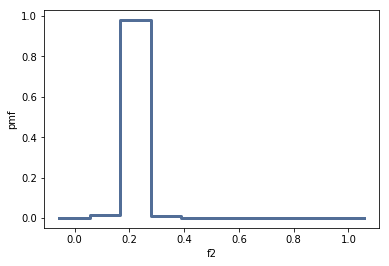

In [5]:
thinkplot.Pmf(trapped_day_one)
thinkplot.Config(xlabel='f2', ylabel='pmf')

** Step 2: the ratio of mosquitoes who wandered into my yard **

I now want to calculate f1. Let's assume the population of mosquitoes N is 500.

In [6]:
from thinkbayes2 import MakePmfFromItems

In [91]:
class Wandered(Suite):
    """
    Calculate the distribution of p1, the mosquitoes who
    wander into my yard
    """
    def __init__(self, f1s, N=1000):
        traps = [Trapped(f1, N) for f1 in f1s]
        Suite.__init__(self, traps)
        
        self.N = N
    
    def Likelihood(self, data, hypo):
        hypo.Log()
        hypo.LogUpdate(data)
        hypo.Exp()
        
        normalizing_factor = hypo.Normalize()
        return normalizing_factor if not np.isnan(normalizing_factor) else 0
    
    def DistOfR(self):
        # This allows me to plot the posterior of p1
        items = [(trapped.f1, prob) for trapped, prob in self.Items()]
        return MakePmfFromItems(items)

For instance, let's assume that p1 is any value between [30, 100]

In [79]:
f1s = np.linspace(0, 1, 10)

In [70]:
wandering = Wandered(f1s=f1s)
wandering.Update(30)

0.9858648517726624

In [65]:
post_wand = wandering.DistOfR()

In [114]:
post_wand

Pmf({0.0: 0.0, 1.0: 0.10143378153728895, 0.77777777777777768: 0.10143378153728895, 0.1111111111111111: 0.18681259522017998, 0.55555555555555558: 0.10143378153728895, 0.88888888888888884: 0.10143378153728895, 0.44444444444444442: 0.10143378153729263, 0.33333333333333331: 0.10143378480876215, 0.22222222222222221: 0.10315093074732042, 0.66666666666666663: 0.10143378153728895})

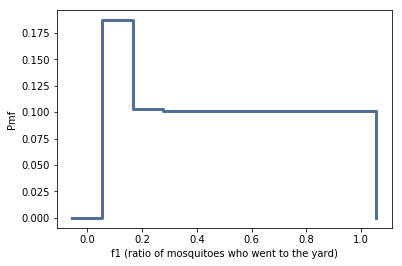

In [67]:
post_wand = wandering.DistOfR()
thinkplot.Pmf(post_wand)
thinkplot.Config(xlabel='f1 (ratio of mosquitoes who went to the yard)', ylabel='Pmf')

** Step 3: The number of mosquitoes in the wetland **

In [130]:
class Total(Suite):
    """
    Calculate the distribution of p1, the mosquitoes who
    wander into my yard
    """
    def __init__(self, f1s, Ns, probs):
        Pmf.__init__(self)
        wanders = [Wandered(f1s, N) for N in Ns]
        for prob, hypo in zip(probs, wanders):
            self.Set(hypo, prob)
        self.Normalize()  
    
    def Likelihood(self, data, hypo):
        return hypo.Update(data)
    
    def DistOfR(self):
        # This allows me to plot the posterior of N
        items = [(wanders.N, prob) for wanders, prob in self.Items()]
        return MakePmfFromItems(items)

In [131]:
Ns = np.linspace(100, 1000, 10, dtype=np.int)
probs = np.ones_like(Ns)

In [132]:
total = Total(f1s, Ns, probs)

In [133]:
total.Update(30)

1.1092154885716332

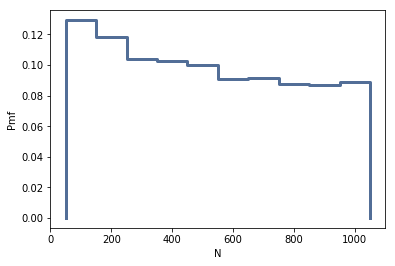

In [134]:
total_N = total.DistOfR()
thinkplot.Pmf(total_N)
thinkplot.Config(xlabel='N', ylabel='Pmf')

** Step 4: Generating a prior for week 2 **

Great! Now that I have a posterior distribution for N the first week, I want to get my prior distribution for N during my second week. I expect the number of mosquitoes to have halved; let's adjust my posterior N from week 1 accordingly, to make a prior N for week 2.

In [137]:
prior_week2 = total_N / 2

In [145]:
Ns_prior = []
probs_prior = []

for N, prob in prior_week2.Items():
    Ns_prior.append(int(N))
    probs_prior.append(prob)

Finally, run the update step again

In [146]:
total_week2 = Total(f1s, Ns_prior, probs_prior)

In [147]:
total_week2.Update(20)

1.3104511321453696

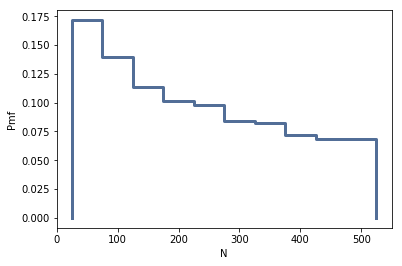

In [148]:
total_N2 = total_week2.DistOfR()
thinkplot.Pmf(total_N2)
thinkplot.Config(xlabel='N', ylabel='Pmf')

Finally, I can calculate how much the population is likely to have changed from one week to the next:

In [149]:
diff = total_N - total_N2

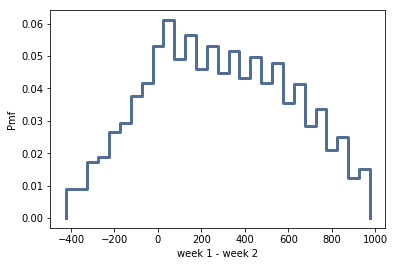

In [152]:
thinkplot.Pmf(diff)
thinkplot.Config(xlabel='week 1 - week 2', ylabel='Pmf')